In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.rcParams["figure.figsize"] = (16, 6)


import random
import re

import optuna
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
train = pd.read_csv('/kaggle/input/chocolate-rating-prediction-ai-edu/chocolate_train.csv')
test = pd.read_csv('/kaggle/input/chocolate-rating-prediction-ai-edu/chocolate_test_new.csv')

In [3]:
train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


**Company** - компания производитель  
**Specific Bean Origin** - географический регион происхождения  
**REF** - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)  
**Review** - дата публикации отзыва  
**Cocoa Percent**- процентное содержание какао  
**Company Location** - страна производитель  
**Rating** - экспертный рейтинг  
**Bean Type** - используемый сорт какао-бобов, если таковой имеется  
**Broad Bean Origin** - географический регион происхождения какао-бобов  

## Preprocessing 

### Маппинг регионов

Поле `Broad Bean Origin` содержит информацию о регионах произрастания какао-бобов. Однако одни и те же регионы могут быть указаны по-разному или перечислены через разделители. 

**Решение:**
1. Разделить значения по разделителям.
2. Дублировать строки, если в одной ячейке указано несколько регионов.
3. Привести названия регионов к единому формату.

In [5]:
def expand_regions(df, split_mode='duplicate'): 
    """
    Обрабатывает колонку region, разделяя ее на отдельные регионы.
    
    Параметры:
    - df: DataFrame с колонкой 'region'
    - split_mode: 'duplicate' (разбивать на строки) или 'first' (оставлять только первый регион)
    
    Возвращает:
    - Обновленный DataFrame
    """
    if split_mode == 'duplicate':
        df_expanded = df.assign(region=df['Broad Bean Origin'].str.split(r'\s*[(,&/]\s*', regex=True)).explode('region')
        df_expanded['region'] = df_expanded['region'].str.strip()
    elif split_mode == 'first':
        df_expanded = df.copy()
        df_expanded['region'] = df_expanded['Broad Bean Origin'].str.split(r'\s*[(,&/]\s*', regex=True).str[0].str.strip()
    else:
        raise ValueError("split_mode должен быть 'duplicate' или 'first'")
    return df_expanded.reset_index(drop=True)

In [6]:
# Словарь соответствий (дочерние -> основное). Названия регионов
region_mapping = {
    'Venezuela': ['Ven.', 'Ven', 'Venez', 'Venezuela/ Ghana', ],
    'Dominican Republic': ['Domincan Republic', 'Dom. Rep', 'D.R.', 'Domin. Rep', 'Dom. Rep.', 'Dominican Rep.', 'DR'],
    'Costa Rica': ['Cost Rica'],
    'Ecuador': ['Ecuad.', 'Ecu.'],
    'Nicaragua': ['Nic.'],
    'Madagascar': ['Mad.', 'Mad'],
    'Brazil': ['Brasil'],
    'Mexico': ['Mex'],
    'Guatemala': ['Guat.'],
    'Sao Tome & Principe': ['Sao Tome', 'Principe'],
    'Papua New Guinea': ['PNG'],
    'Carribean': ['Carribean(DR/Jam/Tri)'],
    'Indonesia': ['Java', 'Bali'],
    'West Africa': ['Africa'],
    'Trinidad': ['Trinidad-Tobago', 'Trinidad']
}

# Функция для замены названий
def standardize_region(region):
    for main_region, aliases in region_mapping.items():
        if region in aliases:
            return main_region
    return region # Если нет в словаре, оставить как есть


### Маппинг сортов какао из поля **Bean Type**

Аналогичная ситуация наблюдается с сортами какао в поле `Bean Type`. 

**Решение:**
Необходимо привести названия сортов к единому виду. Основные виды сортов какао, которые следует учитывать:
- "Forastero"
- "Criollo"
- "Trinitario"
- "Nacional"
- "Arriba"
- "Amelonado"
- "Venezuelan Criollo"
- "Porcelana"
- "Chuncho"
- "Madagascar"
- "Ecuadorian Nacional"
- "Heirloom"
- "Wild Bolivian"
- "Chuao"
- "Porcelana"

Все вариации названий сортов должны быть приведены к этим основным видам.

In [7]:
# Словарь маппинга для разновидностей какао сорта
cacao_map = {
'Criollo': ['Criollo', 'Criollo (Porcelana)', 'Criollo (Amarru)', 'Criollo (Ocumare 77)', 'Criollo (Ocumare 67)',
'Criollo (Ocumare 61)', 'Criollo (Ocumare)', 'Criollo (Wild)', 'Criollo, +'],
'Trinitario': ['Trinitario', 'Trinitario (Amelonado)', 'Trinitario, TCGA', 'Trinitario (85% Criollo)'],
'Forastero': ['Forastero', 'Forastero (Arriba)', 'Forastero (Arriba) ASS', 'Forastero (Arriba) ASSS',
'Forastero (Nacional)', 'Forastero (Parazinho)', 'Forastero (Catongo)', 'Forastero (Amelonado)'],
'Nacional': ['Nacional', 'Nacional (Arriba)'],
'Amazonian': ['Amazon', 'Amazon mix', 'Amazon, ICS'],
'Blend': ['Criollo, Trinitario', 'Trinitario, Criollo', 'Trinitario, Forastero', 'Forastero, Trinitario',
'Trinitario, Nacional', 'Criollo, Forastero', 'Blend-Forastero,Criollo', 'Blend'],
'Unknown': ['\xa0', 'EET', np.nan]
}

# Функция для маппинга типов какао
def map_cacao_type(value):
    for category, variants in cacao_map.items():
        if value in variants:
            return category
    return 'Unknown' # Если нет в словаре

### Маппинг сортов какао из поля **Specific Bean Origin**

Из поля `Specific Bean Origin` также можно извлечь сорты какао-бобов.

In [8]:
known_cocoa_varieties = [
    "Forastero", "Criollo", "Trinitario", "Nacional", "Arriba", "Amelonado",
    "Venezuelan Criollo", "Porcelana", "Chuncho", "Madagascar", "Ecuadorian Nacional", "Heirloom",
    "Wild Bolivian", "Chuao", "Porcelana"
]

# Функция для поиска сорта какао в строке
def find_cocoa_variety(text):
    text = str(text)
    for variety in known_cocoa_varieties:
        if re.search(rf"(^|[\s,.;:]){variety}([\s,.;:]|$)", text, re.IGNORECASE):
            return variety
    return "Unknown" # Если нет в словаре

### Заполнение пропусков и формирование рабочей выборки

In [9]:
def fill_unknown_values(df, region_col, value_col, coefficient=0.7):
    for region in df[region_col].unique():
        # Выбираем строки для текущего региона
        region_data = df[df[region_col] == region]
        
        # Находим наиболее часто встречающиеся значения в регионе
        top_values = region_data[value_col].value_counts().index.tolist()
        
        if 'Unknown' in top_values:
            top_values.remove('Unknown')
        
        if top_values:
            # Если только одно значение, вероятность его выбора равна 1
            if len(top_values) == 1:
                fill_value = top_values[0]
            else:
                # Выбираем случайное значение из наиболее часто встречающихся
                probabilities = [coefficient] + [(1 - coefficient) / (len(top_values) - 1)] * (len(top_values) - 1)
                fill_value = np.random.choice(top_values, p=probabilities)
            
            # Заполняем пропуски
            df.loc[(df[region_col] == region) & (df[value_col] == 'Unknown'), value_col] = fill_value
        else:
            top_values = df[value_col].value_counts().index.tolist()
            if 'Unknown' in top_values:
                top_values.remove('Unknown')
            probabilities = [coefficient] + [(1 - coefficient) / (len(top_values) - 1)] * (len(top_values) - 1)
            fill_value = np.random.choice(top_values, p=probabilities)
            df.loc[df[value_col] == 'Unknown', value_col] = fill_value
    return df

In [10]:
cleaned_train = expand_regions(train)
cleaned_train['region'] = cleaned_train['region'].apply(standardize_region)
# Применяем маппинг
cleaned_train['cacao_category'] = cleaned_train['Bean Type'].apply(map_cacao_type)

In [11]:
cleaned_train.cacao_category.value_counts()

cacao_category
Unknown       655
Trinitario    290
Forastero     142
Criollo       123
Blend          92
Nacional        4
Amazonian       3
Name: count, dtype: int64

In [12]:
cleaned_train["cacao_category_2"] = cleaned_train["Specific Bean Origin"].apply(find_cocoa_variety)
cleaned_train.loc[(cleaned_train.cacao_category == 'Unknown') & (cleaned_train.cacao_category_2 != 'Unknown'), 'cacao_category'] = cleaned_train.cacao_category_2
cleaned_train = fill_unknown_values(cleaned_train, 'region', 'cacao_category')

In [13]:
cleaned_test = expand_regions(test, 'first')
cleaned_test['region'] = cleaned_test['region'].apply(standardize_region)
cleaned_test['region'] = cleaned_test['region'].apply(lambda x: 'Venezuela' if x not in cleaned_train['region'].unique() else x)

In [14]:
cleaned_test['region'].unique()

array(['Trinidad', '', 'Belize', 'Madagascar', 'Costa Rica', 'Colombia',
       'Venezuela', 'Peru', 'Grenada', 'Ghana', 'Vietnam',
       'Sao Tome & Principe', 'Ecuador', 'Nicaragua', 'Guatemala',
       'West Africa', 'Papua New Guinea', 'Bolivia', 'Hawaii',
       'Dominican Republic', 'Jamaica', 'Mexico', 'Indonesia',
       'South America', 'Philippines', 'Brazil', 'Congo', 'Uganda',
       'Tanzania', 'Honduras', 'Australia', 'Panama', 'St. Lucia',
       'Vanuatu', 'Ivory Coast', 'Carribean', 'Haiti', 'Cuba', 'Fiji',
       'Togo', 'India', 'Solomon Islands'], dtype=object)

In [15]:
cleaned_test['cacao_category'] = cleaned_test['Bean Type'].apply(map_cacao_type)
cleaned_test["cacao_category_2"] = cleaned_test["Specific Bean Origin"].apply(find_cocoa_variety)
cleaned_test.loc[(cleaned_test.cacao_category == 'Unknown') & (cleaned_test.cacao_category_2 != 'Unknown'), 'cacao_category'] = cleaned_test.cacao_category_2
cleaned_test = fill_unknown_values(cleaned_test, 'region', 'cacao_category')

In [16]:
cleaned_test.cacao_category.value_counts()

cacao_category
Trinitario       233
Criollo          136
Forastero        124
Blend             39
Nacional           3
Amazonian          2
Heirloom           1
Porcelana          1
Wild Bolivian      1
Name: count, dtype: int64

In [17]:
cleaned_test.region.unique()

array(['Trinidad', '', 'Belize', 'Madagascar', 'Costa Rica', 'Colombia',
       'Venezuela', 'Peru', 'Grenada', 'Ghana', 'Vietnam',
       'Sao Tome & Principe', 'Ecuador', 'Nicaragua', 'Guatemala',
       'West Africa', 'Papua New Guinea', 'Bolivia', 'Hawaii',
       'Dominican Republic', 'Jamaica', 'Mexico', 'Indonesia',
       'South America', 'Philippines', 'Brazil', 'Congo', 'Uganda',
       'Tanzania', 'Honduras', 'Australia', 'Panama', 'St. Lucia',
       'Vanuatu', 'Ivory Coast', 'Carribean', 'Haiti', 'Cuba', 'Fiji',
       'Togo', 'India', 'Solomon Islands'], dtype=object)

In [18]:
print('Train shape: {}, {}'.format(*cleaned_train.shape))
print('Test shape: {}, {}'.format(*cleaned_test.shape))

Train shape: 1309, 12
Test shape: 540, 11


In [19]:
cleaned_train.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               3
Broad Bean Origin       1
region                  1
cacao_category          0
cacao_category_2        0
dtype: int64

In [20]:
for column in cleaned_train.columns:
    most_frequent_value = cleaned_train[column].mode()[0]
    cleaned_train[column].fillna(most_frequent_value, inplace=True)

In [21]:
for column in cleaned_test.columns:
    most_frequent_value = cleaned_test[column].mode()[0]
    cleaned_test[column].fillna(most_frequent_value, inplace=True)

In [22]:
for col in cleaned_train.columns:
    print(f'Nunique {col}: {cleaned_train[col].nunique()}')

Nunique Company: 376
Nunique Specific Bean Origin: 762
Nunique REF: 433
Nunique Review: 12
Nunique Cocoa Percent: 40
Nunique Company Location: 58
Nunique Rating: 13
Nunique Bean Type: 38
Nunique Broad Bean Origin: 84
Nunique region: 55
Nunique cacao_category: 12
Nunique cacao_category_2: 10


In [23]:
cleaned_train["Cocoa Percent"] = cleaned_train["Cocoa Percent"].str[:-1].astype('float64')
cleaned_test["Cocoa Percent"] = cleaned_test["Cocoa Percent"].str[:-1].astype('float64')

In [24]:
train_shape = cleaned_train.shape
cleaned_train.drop_duplicates(subset=cleaned_train.columns.values[1:], keep='last', inplace=True)
if (train_shape == cleaned_train.shape):
    print("# No duplicates")
else:
    print(f"# Duplicates found, {train_shape[0] - cleaned_train.shape[0]} num.")

# Duplicates found, 6 num.


## EDA

In [25]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [26]:
cat_param = ['region', 'cacao_category', 'Company Location', 'Review']
num_param = ['REF', 'Cocoa Percent', 'Rating']

In [27]:
cleaned_train['dataset'] = 'train'
cleaned_test['dataset'] = 'test'

visualisation_df = pd.concat([cleaned_train, cleaned_test], axis=0)

cleaned_train.drop(columns='dataset', inplace=True)
cleaned_test.drop(columns='dataset', inplace=True)

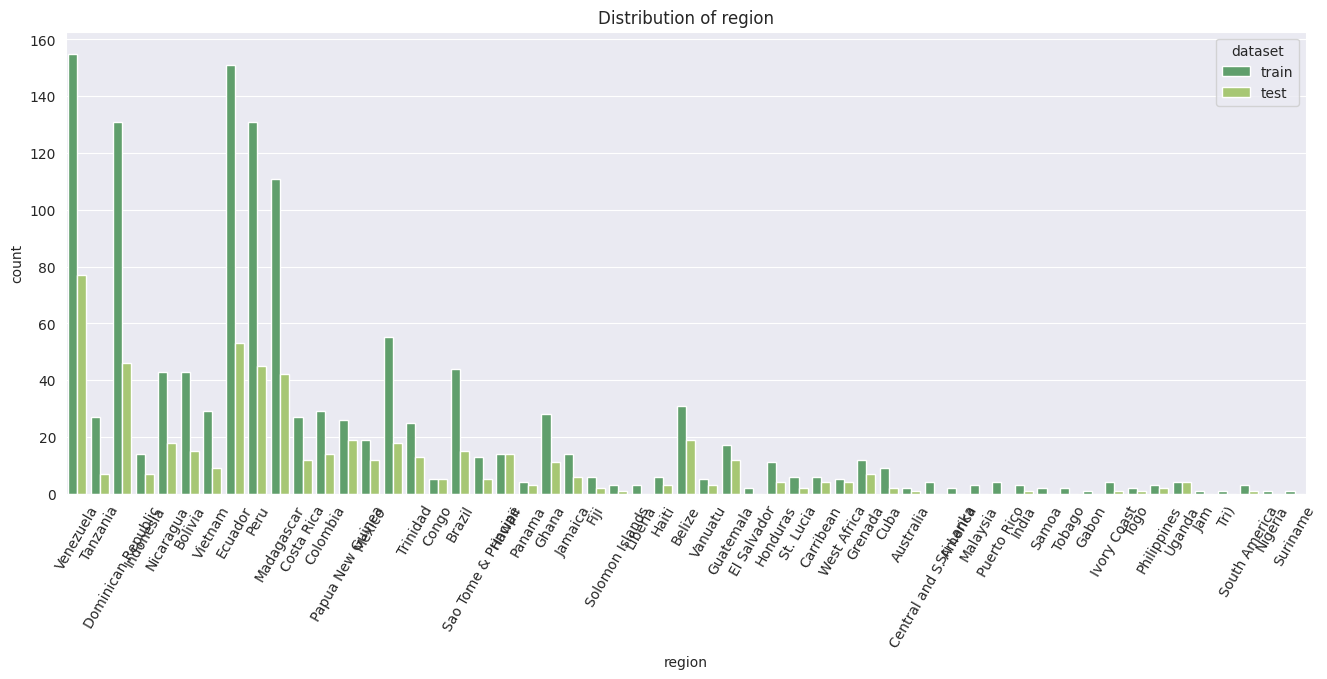

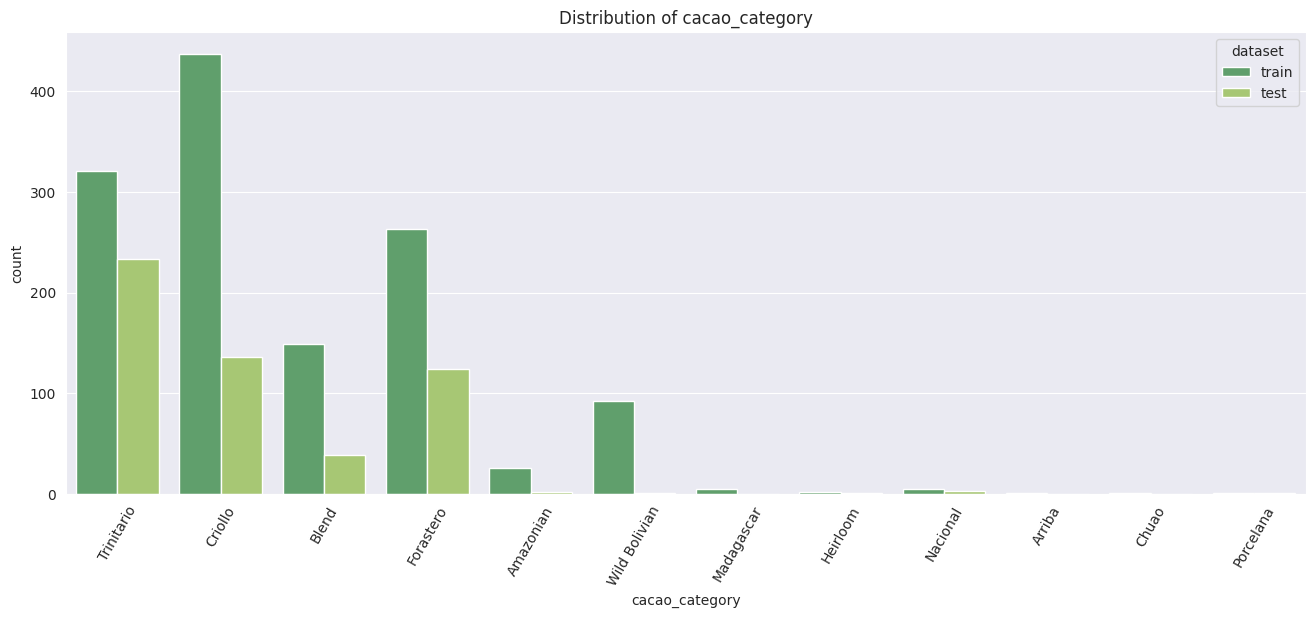

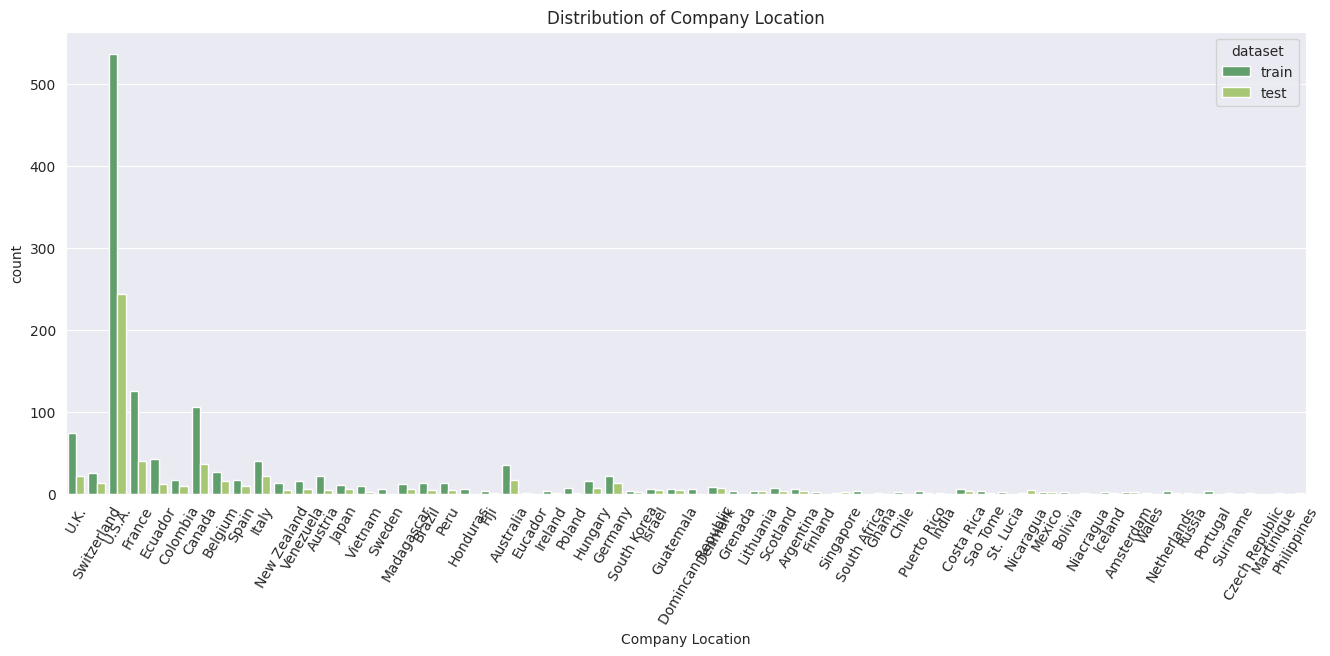

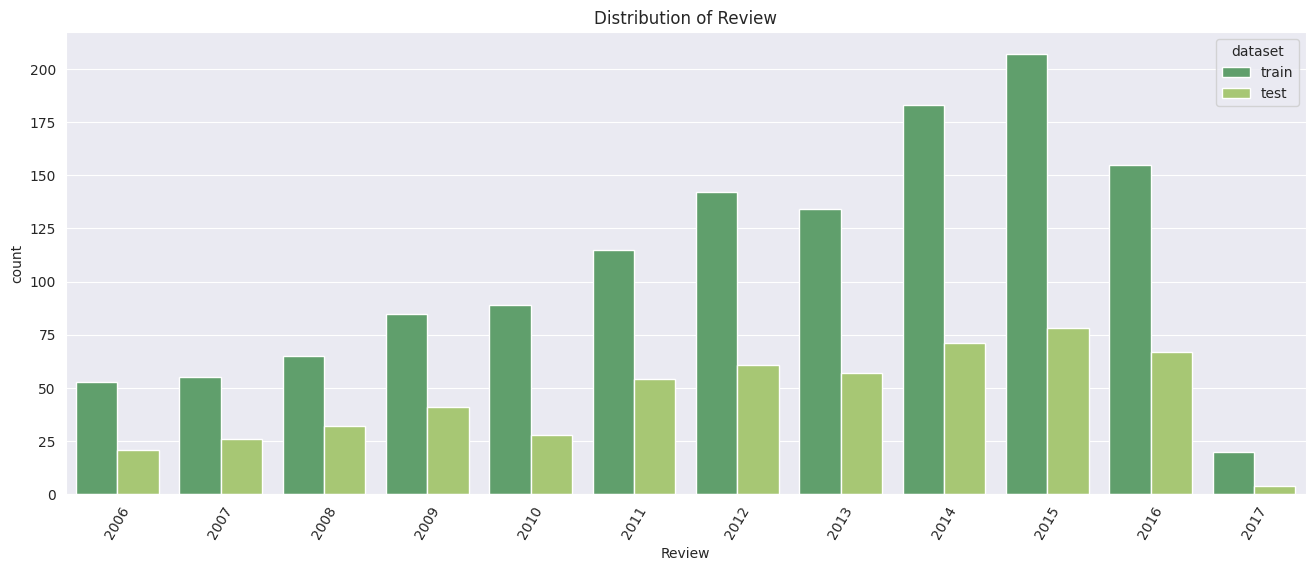

In [28]:
for feature in cat_param:
    sns.countplot(data = visualisation_df, x=feature, hue='dataset', palette='summer')
    plt.xticks(rotation=60)
    plt.title(f'Distribution of {feature}')
    plt.show()

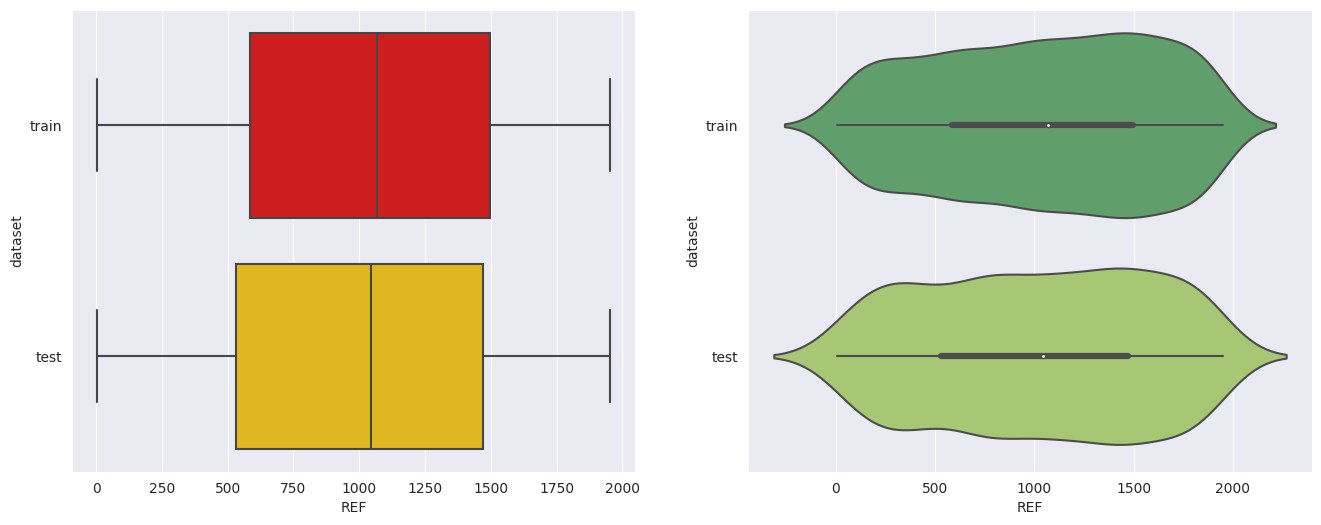

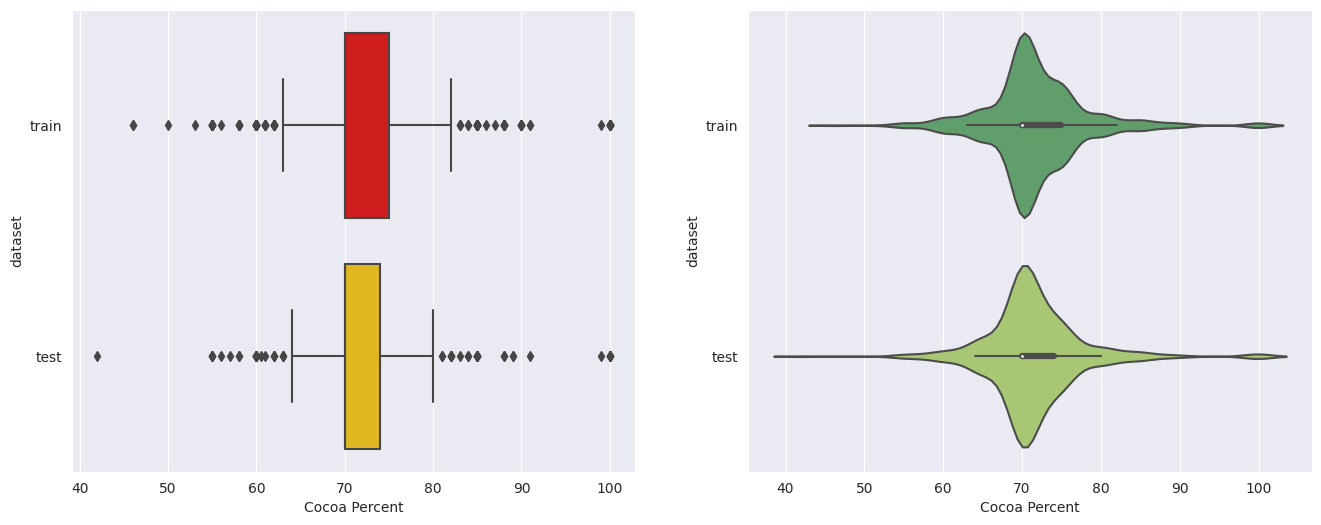

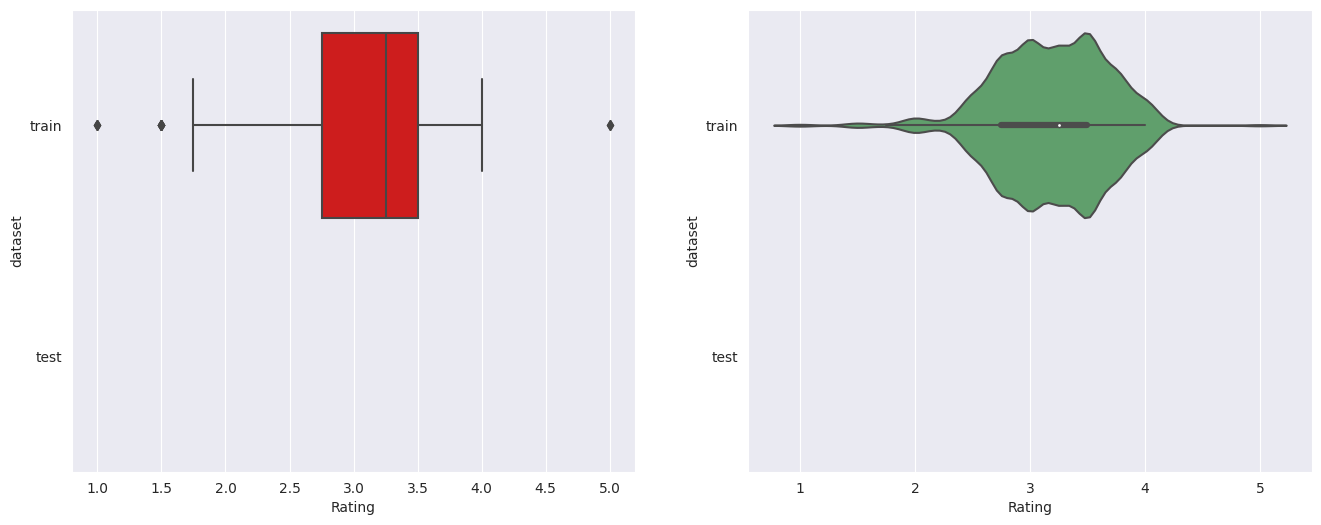

In [29]:
for features in num_param:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.boxplot(data=visualisation_df, y='dataset', x=features, ax=ax[0], orient='h', palette='hot')
    sns.violinplot(data=visualisation_df, y='dataset', x=features, ax=ax[1], palette='summer')
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


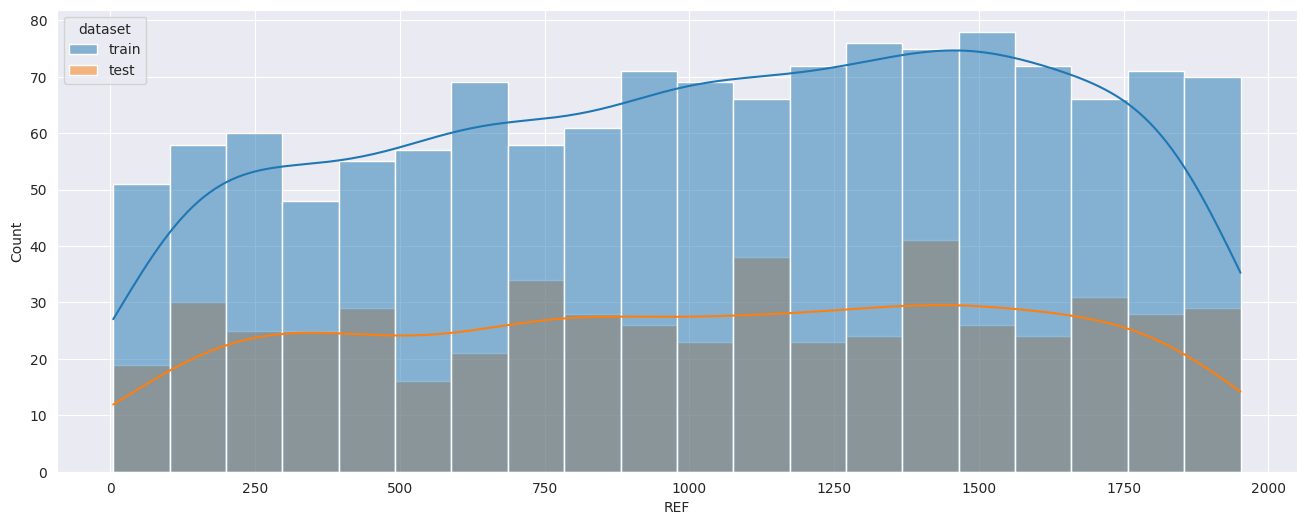

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


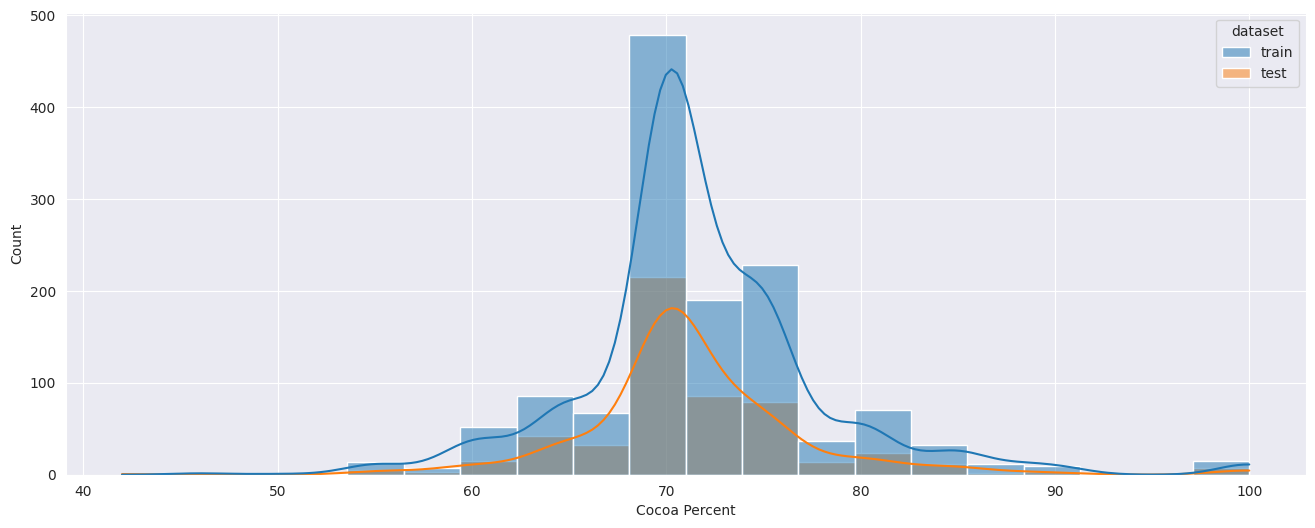

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


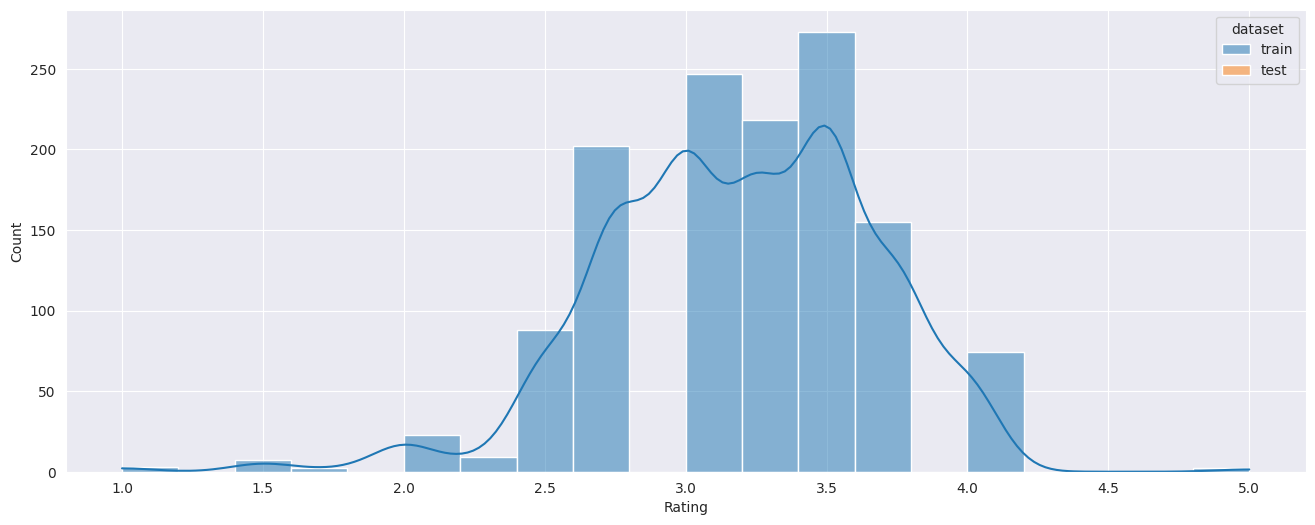

In [30]:
for features in num_param:
    sns.histplot(data=visualisation_df, hue='dataset', x=features, kde=True, bins=20)
    plt.show()

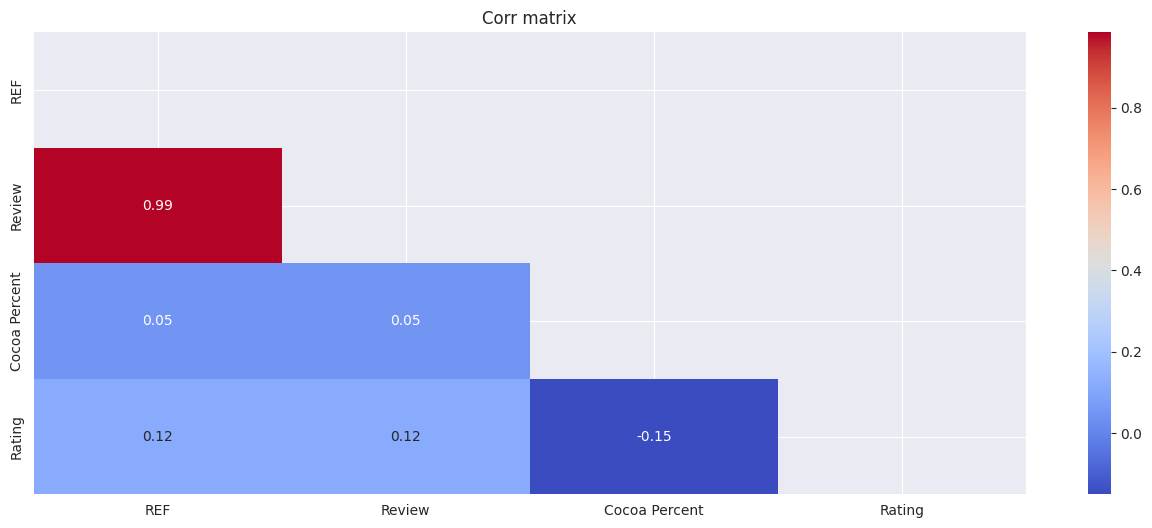

In [31]:
correlation_matrix = cleaned_train.corr(numeric_only=True) 
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', mask=mask)
plt.title('Corr matrix')
plt.show()

In [32]:
cols = [
    'Company',
    'Specific Bean Origin',
    'REF',
    'Review',
    'Cocoa Percent',
    'Company Location',
    'region',
    'cacao_category'
]

In [33]:
X = cleaned_train.loc[:, cols]
target = cleaned_train['Rating']
test = cleaned_test.loc[:, cols]

In [34]:
mm_scaler = MinMaxScaler()
# scaler = StandardScaler()

X['REF'] = mm_scaler.fit_transform(X[['REF']])  
test['REF'] = mm_scaler.transform(cleaned_test[['REF']])

In [35]:
mm_scaler = MinMaxScaler()

X['Cocoa Percent'] = mm_scaler.fit_transform(X[['Cocoa Percent']])  
test['Cocoa Percent'] = mm_scaler.transform(test[['Cocoa Percent']])

In [36]:
X

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,region,cacao_category
0,Willie's Cacao,Rio Caribe,0.232152,2009,0.481481,U.K.,Venezuela,Trinitario
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",0.258346,2010,0.481481,Switzerland,Venezuela,Criollo
2,Dark Forest,Tanzania,0.795583,2015,0.444444,U.S.A.,Tanzania,Blend
3,Brasstown aka It's Chocolate,Cooproagro,0.575244,2013,0.481481,U.S.A.,Dominican Republic,Trinitario
4,Pralus,"Java, Indonesie",0.013867,2006,0.537037,France,Indonesia,Criollo
...,...,...,...,...,...,...,...,...
1304,Artisan du Chocolat,Madagascar,0.183873,2009,0.629630,U.K.,Madagascar,Blend
1305,Marana,Cusco,0.965074,2016,0.444444,Peru,Peru,Criollo
1306,Arete,Nacional,0.785311,2015,0.407407,U.S.A.,Peru,Forastero
1307,Fresco,"Conacado, #212, LR, SC",0.327170,2011,0.481481,U.S.A.,Dominican Republic,Criollo


## Обучение и подбор гиперпараметров

In [37]:
def objective_catboost(trial):
    max_depth = 4 #trial.suggest_int("max_depth", 3, 5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    n_estimators = trial.suggest_int("n_estimators", 1200, 2000)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1, 10)
    random_strength = trial.suggest_float("random_strength", 0, 10)
    bagging_temperature = trial.suggest_float("bagging_temperature", 0, 1)
    # border_count = trial.suggest_int("border_count", 32, 255)

    model = CatBoostRegressor(
        cat_features=[0, 1, 3, 5, 6, 7],
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        bagging_temperature=bagging_temperature,
        # border_count=border_count,
        silent=True
    )

    score = cross_val_score(model, X, target, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=100)

[I 2025-02-11 16:00:07,201] A new study created in memory with name: no-name-2c5de5e1-d05f-42fd-93a3-7fc58f6e56a8
[I 2025-02-11 16:00:17,791] Trial 0 finished with value: 0.19025622133585363 and parameters: {'learning_rate': 0.05405235723039713, 'n_estimators': 1812, 'l2_leaf_reg': 6.254911508227572, 'random_strength': 0.45534490744016387, 'bagging_temperature': 0.24612487898822755}. Best is trial 0 with value: 0.19025622133585363.
[I 2025-02-11 16:00:25,812] Trial 1 finished with value: 0.05668151108337812 and parameters: {'learning_rate': 0.37485708605991014, 'n_estimators': 1671, 'l2_leaf_reg': 3.473539223811713, 'random_strength': 5.474039225154992, 'bagging_temperature': 0.588461408739549}. Best is trial 0 with value: 0.19025622133585363.
[I 2025-02-11 16:00:32,459] Trial 2 finished with value: 0.19035238370240015 and parameters: {'learning_rate': 0.0021235291738116624, 'n_estimators': 1517, 'l2_leaf_reg': 4.604226339633002, 'random_strength': 0.7762237415989914, 'bagging_temperat

In [38]:
!pip install plotly -q

In [39]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_contour, plot_slice
plot_optimization_history(study).show()
plot_param_importances(study).show()
plot_contour(study, params=["learning_rate", "n_estimators"]).show()
plot_contour(study, params=["l2_leaf_reg", "random_strength"]).show()
plot_slice(study, params=["learning_rate", "n_estimators", "l2_leaf_reg"]).show()

In [40]:
params = study.best_params
model = CatBoostRegressor(
        cat_features=[0, 1, 5, 6, 7],
        max_depth=4,
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        l2_leaf_reg=params['l2_leaf_reg'],
        random_strength=params['random_strength'],
        bagging_temperature=params['bagging_temperature'],
        # border_count=params['border_count'],
        silent=True
    )
model.fit(X, target)

In [41]:
pred = model.predict(test)

In [42]:
test = test.copy()
result = pd.DataFrame()
result['id'] = np.arange(len(test))
result['Rating'] = pred

result[['id','Rating']].to_csv("submission.csv", index=False)

**На самом деле, датасет оставляет желать лучшего: данных для обучения недостаточно, при этом много шумных и избыточных параметров, что делает извлечение полезной информации крайне сложной задачей. Улучшить результат может помочь самостоятельная обработка и очистка категорий. Надеюсь, моя тетрадка оказалась для вас полезной. Буду благодарен за upvote!**